# ETL SOIL Notebook

### Install project's libraries

In [59]:
%pwd
%pip install -r requirements.txt
%pip install pymysql

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 44.8/44.8 kB 618.2 kB/s eta 0:00:00 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Import system and project libraries

In [60]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [61]:
from sqlalchemy import create_engine
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 0. Connect to the database and extract the data

### Database connection

In [64]:
# Establish the connection
# sqlalchemy uses a standard URL for connections: 
# 'mysql+pymysql://<user>:<password>@<host>/<dbname>'
DATABASE_CON = os.getenv('DATABASE_CON')

try:
    # Create a SQLAlchemy engine
    engine = create_engine(DATABASE_CON)
    # Attempt to connect to the database
    with engine.connect() as connection:
        print("Database connection established successfully.")
except SQLAlchemyError as e:
    # Handle the error
    print(f"An error occurred when connecting to the database: {e}")

Database connection established successfully.


### Query to extract the soil_ICP dataframe

In [4]:
soil_icp_df = pd.read_sql_query("""
                        -- This query extracts the information necessary to shape the soil_icp dataframe
                        
                        SELECT sr.id, s.name, sr.sample, sr.rep,
                            MAX(CASE WHEN n.symbol = 'B' THEN rn.value ELSE 0 END) AS B,
                            MAX(CASE WHEN n.symbol = 'Mg' THEN rn.value ELSE 0 END) AS Mg,
                            MAX(CASE WHEN n.symbol = 'P' THEN rn.value ELSE 0 END) AS P,
                            MAX(CASE WHEN n.symbol = 'S' THEN rn.value ELSE 0 END) AS S,
                            MAX(CASE WHEN n.symbol = 'K' THEN rn.value ELSE 0 END) AS K,
                            MAX(CASE WHEN n.symbol = 'Ca' THEN rn.value ELSE 0 END) AS Ca,
                            MAX(CASE WHEN n.symbol = 'Mn' THEN rn.value ELSE 0 END) AS Mn,
                            MAX(CASE WHEN n.symbol = 'Fe' THEN rn.value ELSE 0 END) AS Fe,
                            MAX(CASE WHEN n.symbol = 'Cu' THEN rn.value ELSE 0 END) AS Cu,
                            MAX(CASE WHEN n.symbol = 'Zn' THEN rn.value ELSE 0 END) AS Zn
                        FROM soil_results AS sr
                        JOIN soils AS s ON sr.soil_id = s.id
                        JOIN result_nutrients AS rn ON sr.id = rn.soil_result_id
                        JOIN nutrients AS n ON rn.nutrient_id = n.id
                        WHERE sr.analysis_method_id  = 2
                        GROUP BY sr.id
                        ORDER BY sr.id;""", engine)

soil_icp_df = soil_icp_df.rename(columns={'name': 'soil'})

### Query to extract the soil_HHXRF dataframe

In [6]:
soil_hhxrf_df = pd.read_sql_query("""
                        -- This query extracts the information necessary to shape the soil_icp dataframe
                        
                        SELECT sr.id, s.name, sr.sample, sr.rep,
                            MAX(CASE WHEN n.symbol = 'B' THEN rn.value ELSE 0 END) AS B,
                            MAX(CASE WHEN n.symbol = 'Mg' THEN rn.value ELSE 0 END) AS Mg,
                            MAX(CASE WHEN n.symbol = 'P' THEN rn.value ELSE 0 END) AS P,
                            MAX(CASE WHEN n.symbol = 'S' THEN rn.value ELSE 0 END) AS S,
                            MAX(CASE WHEN n.symbol = 'K' THEN rn.value ELSE 0 END) AS K,
                            MAX(CASE WHEN n.symbol = 'Ca' THEN rn.value ELSE 0 END) AS Ca,
                            MAX(CASE WHEN n.symbol = 'Mn' THEN rn.value ELSE 0 END) AS Mn,
                            MAX(CASE WHEN n.symbol = 'Fe' THEN rn.value ELSE 0 END) AS Fe,
                            MAX(CASE WHEN n.symbol = 'Cu' THEN rn.value ELSE 0 END) AS Cu,
                            MAX(CASE WHEN n.symbol = 'Zn' THEN rn.value ELSE 0 END) AS Zn
                        FROM soil_results AS sr
                        JOIN soils AS s ON sr.soil_id = s.id
                        JOIN result_nutrients AS rn ON sr.id = rn.soil_result_id
                        JOIN nutrients AS n ON rn.nutrient_id = n.id
                        WHERE sr.analysis_method_id  = 3
                        GROUP BY sr.id
                        ORDER BY sr.id;""", engine)




#### Correct index `id` of `soil_hhxrf_df` so that it starts at `1`

In [10]:
soil_hhxrf_df = soil_hhxrf_df.drop('id', axis=1)
soil_hhxrf_df.reset_index(drop=True, inplace=True)
soil_hhxrf_df.index += 1
soil_hhxrf_df['id'] = soil_hhxrf_df.index

soil_hhxrf_df = soil_hhxrf_df.rename(columns={'name': 'soil'})

## 2. Creation of a table of adequate ranges of nutrients

#### Nutrient range for sandy soils

In [11]:
nutrients_sandy = ['limit','B', 'Mg', 'P', 'S', 'K', 'Ca', 'Mn', 'Fe', 'Cu', 'Zn']
sandy_soil_nutrient_range = pd.DataFrame(columns=nutrients_sandy)
sandy_soil_nutrient_range.loc[0] = ['inferior', '0.5', '51', '23', '30', '66', '400', '10', '2.6', '1.0', '3.1']  # Values for the first row
sandy_soil_nutrient_range.loc[1] = ['superior','1.0', '250', '32', '40', '90', '600', '20', '4.7', '5.5', '20']  # Values for the second row
print(sandy_soil_nutrient_range)

      limit    B   Mg   P   S   K   Ca  Mn   Fe   Cu   Zn
0  inferior  0.5   51  23  30  66  400  10  2.6  1.0  3.1
1  superior  1.0  250  32  40  90  600  20  4.7  5.5   20


#### Nutrient range for Medium-textured soils

In [13]:
nutrients_medium = ['limit','B', 'Mg', 'P', 'S', 'K', 'Ca', 'Mn', 'Fe', 'Cu', 'Zn']
soil_medium_nutrient_range = pd.DataFrame(columns=nutrients_medium)
soil_medium_nutrient_range.loc[0] = ['inferior', '0.9', '101', '11', '30', '81', '601', '10', '2.6', '1.0', '3.1']  # Values for the first row
soil_medium_nutrient_range.loc[1] = ['superior','1.5', '500', '20', '40', '110', '1000', '20', '4.7', '5.5', '20']  # Values for the second row
print(soil_medium_nutrient_range)

      limit    B   Mg   P   S    K    Ca  Mn   Fe   Cu   Zn
0  inferior  0.9  101  11  30   81   601  10  2.6  1.0  3.1
1  superior  1.5  500  20  40  110  1000  20  4.7  5.5   20


## 3. Creation of a table of soil types

In [8]:
soil_types = ['soil', 'type']
soil_types_df = pd.DataFrame(columns=soil_types)

# Determines the soil type
def determine_soil_type(soil_name):
    if soil_name == 'patrick':
        return 'medium'
    elif soil_name == 'werner':
        return 'medium'
    else:
        return 'sandy'

soil_types_df.loc[0] = ['krm', determine_soil_type('krm')]
soil_types_df.loc[1] = ['lobby', determine_soil_type('lobby')]
soil_types_df.loc[2] = ['yenter', determine_soil_type('yenter')]
soil_types_df.loc[3] = ['pow', determine_soil_type('pow')]
soil_types_df.loc[4] = ['c15', determine_soil_type('c15')]
soil_types_df.loc[5] = ['c21', determine_soil_type('c21')]
soil_types_df.loc[6] = ['c28', determine_soil_type('c28')]
soil_types_df.loc[7] = ['coloma', determine_soil_type('coloma')]
soil_types_df.loc[8] = ['patrick', determine_soil_type('patrick')]
soil_types_df.loc[9] = ['werner', determine_soil_type('werner')]
soil_types_df.loc[10] = ['wormet', determine_soil_type('wormet')]
print(soil_types_df)

       soil    type
0       krm   sandy
1     lobby   sandy
2    yenter   sandy
3       pow   sandy
4       c15   sandy
5       c21   sandy
6       c28   sandy
7    coloma   sandy
8   patrick  medium
9    werner  medium
10   wormet   sandy


## 4. Checking if the ICP values are in the range

In [17]:
# Initialize the new DataFrame
icp_classification = ['id'] + list(soil_icp_df.columns[1:4]) + nutrients_sandy[1:]
icp_classification_df = pd.DataFrame(columns=icp_classification)

# Iterate over soil_icp_df to fill icp_classification_df
for id, row in soil_icp_df.iterrows():
    new_id = id + 1
    new_row = [new_id] + list(row[1:4])

    # Determine soil type
    soil_name = row.iloc[1]
    soil_type = soil_types_df[soil_types_df['soil'] == soil_name]['type'].iloc[0]

    # Select the appropriate nutrient range table
    nutrient_range_df = sandy_soil_nutrient_range if soil_type == 'sandy' else soil_medium_nutrient_range

    # Compare and categorize values
    for element in nutrients_sandy[1:]:
        element_value = row[element]

        if element_value == 0:  # Check if the value is zero
            category = 'NA'  # Assign None (which will be NULL in CSV)
        else:
            lower_limit = float(nutrient_range_df[nutrient_range_df['limit'] == 'inferior'][element].iloc[0])
            upper_limit = float(nutrient_range_df[nutrient_range_df['limit'] == 'superior'][element].iloc[0])


            if element_value < lower_limit:
                category = 'low'
            elif element_value > upper_limit:
                category = 'high'
            else:
                category = 'optimum'
        
        new_row.append(category)

    icp_classification_df.loc[new_id] = new_row

      id    soil sample  rep   B    Mg     P   S     K    Ca    Mn    Fe  Cu  \
1      1  coloma      1    1  NA    NA    NA  NA  high  high  high  high  NA   
2      2  coloma      2    1  NA  high    NA  NA  high  high  high  high  NA   
3      3  coloma      2    2  NA  high    NA  NA  high  high  high  high  NA   
4      4  coloma      2    3  NA  high    NA  NA  high  high  high  high  NA   
5      5  coloma      3    1  NA  high    NA  NA  high  high  high  high  NA   
..   ...     ...    ...  ...  ..   ...   ...  ..   ...   ...   ...   ...  ..   
785  785     c28     18    2  NA  high  high  NA  high  high  high  high  NA   
786  786     c28     18    3  NA  high  high  NA  high  high  high  high  NA   
787  787     c28     19    1  NA  high  high  NA  high  high  high  high  NA   
788  788     c28     19    2  NA  high  high  NA  high  high  high  high  NA   
789  789     c28     19    3  NA  high  high  NA  high  high  high  high  NA   

          Zn  
1    optimum  
2    opti

#### Export icp_classification_df to a CSV file

In [18]:
icp_classification_df.to_csv('icp_classification_df.csv', index = False)
print(icp_classification_df)

      id    soil sample  rep   B    Mg     P   S     K    Ca    Mn    Fe  Cu  \
1      1  coloma      1    1  NA    NA    NA  NA  high  high  high  high  NA   
2      2  coloma      2    1  NA  high    NA  NA  high  high  high  high  NA   
3      3  coloma      2    2  NA  high    NA  NA  high  high  high  high  NA   
4      4  coloma      2    3  NA  high    NA  NA  high  high  high  high  NA   
5      5  coloma      3    1  NA  high    NA  NA  high  high  high  high  NA   
..   ...     ...    ...  ...  ..   ...   ...  ..   ...   ...   ...   ...  ..   
785  785     c28     18    2  NA  high  high  NA  high  high  high  high  NA   
786  786     c28     18    3  NA  high  high  NA  high  high  high  high  NA   
787  787     c28     19    1  NA  high  high  NA  high  high  high  high  NA   
788  788     c28     19    2  NA  high  high  NA  high  high  high  high  NA   
789  789     c28     19    3  NA  high  high  NA  high  high  high  high  NA   

          Zn  
1    optimum  
2    opti

## 5. Count each type of classification

In [21]:
soil_column = icp_classification_df.columns[1]

def calculate_element_counts(element_column):
    # Group by soil type and count occurrences of each classification, including 'NA' as a string
    element_counts = icp_classification_df.groupby(soil_column)[element_column].value_counts().unstack(fill_value=0)

    # Add missing columns with default value 0 if they do not exist
    for col in ['NA', 'optimum', 'low', 'high']:
        if col not in element_counts.columns:
            element_counts[col] = 0

    # Reorder columns
    element_counts = element_counts[['NA', 'optimum', 'low', 'high']]

    # Reset index to make 'soil' a column
    element_counts.reset_index(inplace=True)

    return element_counts

--B table--
B     soil   NA  optimum  low  high
0      c15  120        0    0     1
1      c21  141        0    0     1
2      c28   57        0    0     0
3   coloma  129        0    0     4
4      krm    0        0    0    48
5    lobby   30       11    0   139
6  patrick   15        0    0    39
7   werner    0        0    0    54
--Mg table--
Mg     soil  NA  optimum  low  high
0       c15   2       10    0   109
1       c21  42        5    3    92
2       c28   0        2    0    55
3    coloma   1       17    0   115
4       krm   0        0    0    48
5     lobby   1        0    0   179
6   patrick   0        2    0    52
7    werner   0        0    0    54
--P table--
P     soil   NA  optimum  low  high
0      c15    8        2    4   107
1      c21   52        3    2    85
2      c28    0        0    0    57
3   coloma  122        0    0    11
4      krm    0        0    0    48
5    lobby    4        0    1   175
6  patrick    1        1    0    52
7   werner    0        0   

#### Calculate and print counts for each element

In [23]:
# List of element columns to process
elements = ['B', 'Mg', 'P', 'S', 'K', 'Ca', 'Mn', 'Fe', 'Cu', 'Zn']

for element in elements:
    element_counts = calculate_element_counts(element)
    print(f"--{element} table--")
    print(element_counts)

--B table--
B     soil   NA  optimum  low  high
0      c15  120        0    0     1
1      c21  141        0    0     1
2      c28   57        0    0     0
3   coloma  129        0    0     4
4      krm    0        0    0    48
5    lobby   30       11    0   139
6  patrick   15        0    0    39
7   werner    0        0    0    54
--Mg table--
Mg     soil  NA  optimum  low  high
0       c15   2       10    0   109
1       c21  42        5    3    92
2       c28   0        2    0    55
3    coloma   1       17    0   115
4       krm   0        0    0    48
5     lobby   1        0    0   179
6   patrick   0        2    0    52
7    werner   0        0    0    54
--P table--
P     soil   NA  optimum  low  high
0      c15    8        2    4   107
1      c21   52        3    2    85
2      c28    0        0    0    57
3   coloma  122        0    0    11
4      krm    0        0    0    48
5    lobby    4        0    1   175
6  patrick    1        1    0    52
7   werner    0        0   

## 6. Bar charts for each element

In [24]:
def plot_element_counts(element_counts, element_name):
    # Set figure size for better readability
    plt.figure(figsize=(12, 6))

    # Number of soil types
    n_soils = len(element_counts)
    # Width of a bar
    bar_width = 0.2

    # Positions of bars on the x-axis
    r1 = np.arange(n_soils)
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]

    # Plotting the data
    plt.bar(r1, element_counts['NA'], color='b', width=bar_width, edgecolor='gray', label='NA')
    plt.bar(r2, element_counts['optimum'], color='g', width=bar_width, edgecolor='gray', label='optimum')
    plt.bar(r3, element_counts['low'], color='r', width=bar_width, edgecolor='gray', label='low')
    plt.bar(r4, element_counts['high'], color='y', width=bar_width, edgecolor='gray', label='high')

    # Adding labels and title
    plt.xlabel('Soil Type', fontweight='bold')
    plt.ylabel('Frequency', fontweight='bold')
    plt.xticks([r + bar_width/2 for r in range(n_soils)], element_counts[soil_column], rotation=45)
    plt.title(f'Frequency of {element_name} Classifications by Soil Type')
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

#### Calculate counts and plot graph for each element

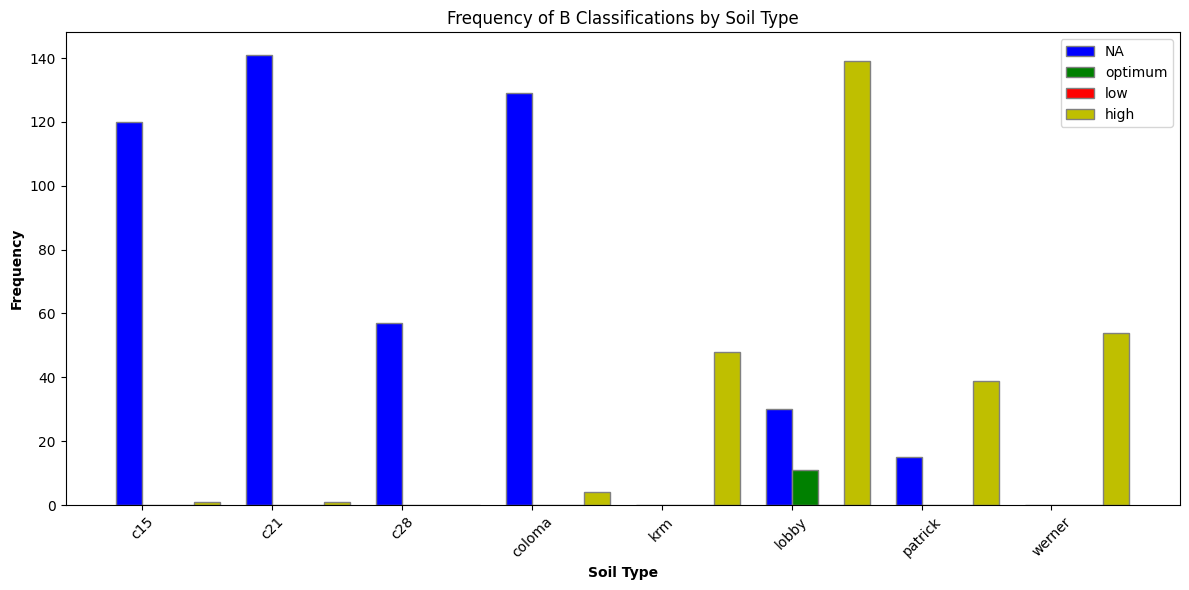

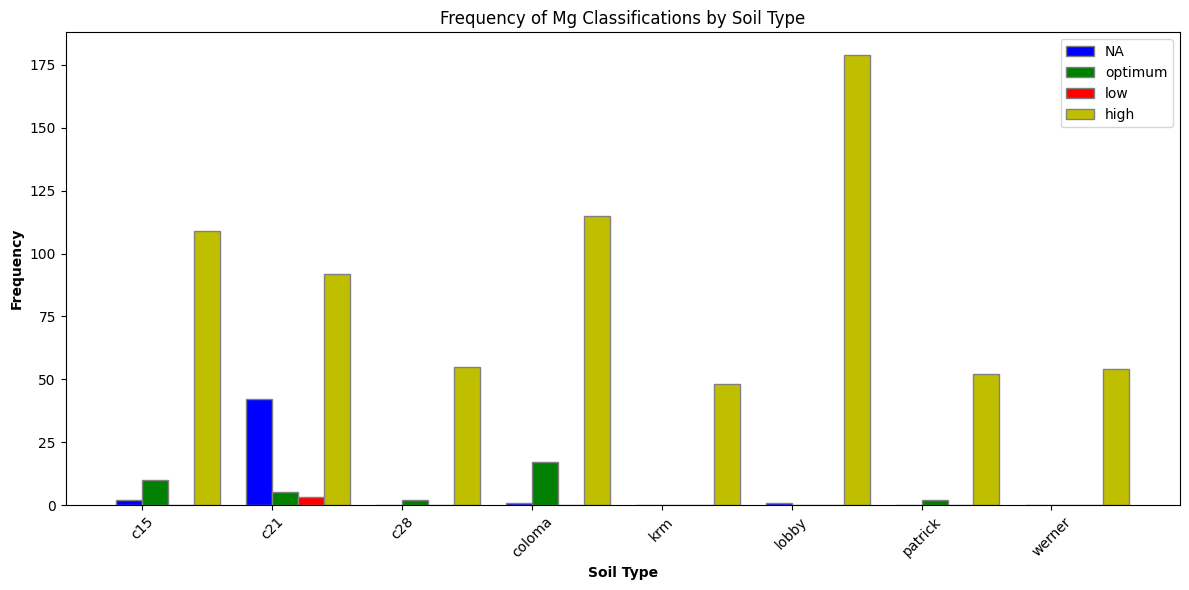

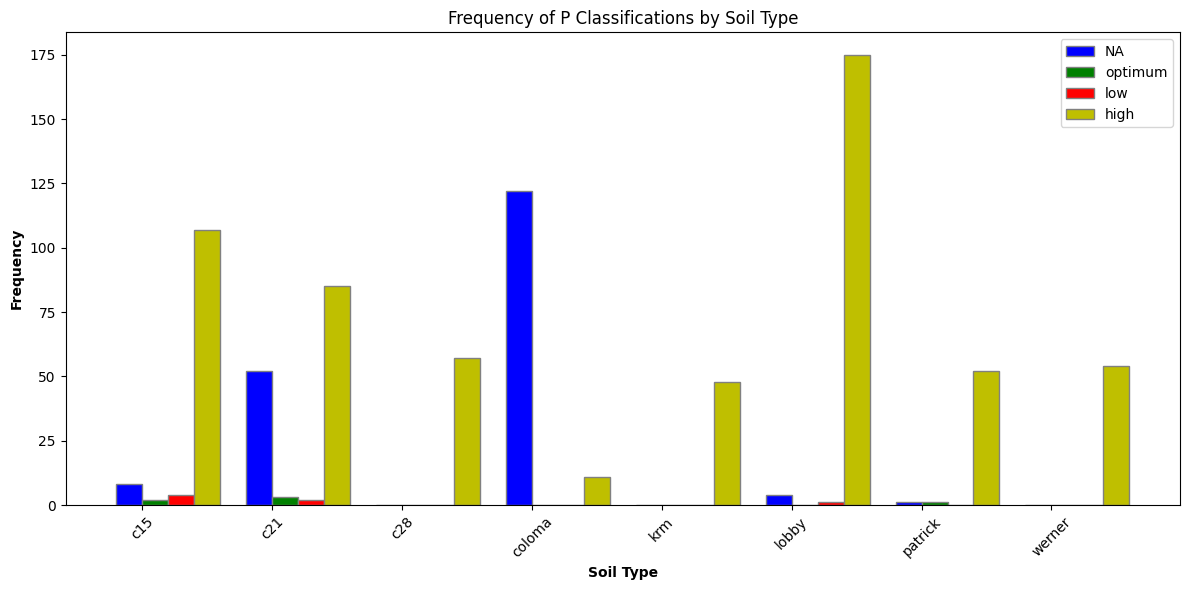

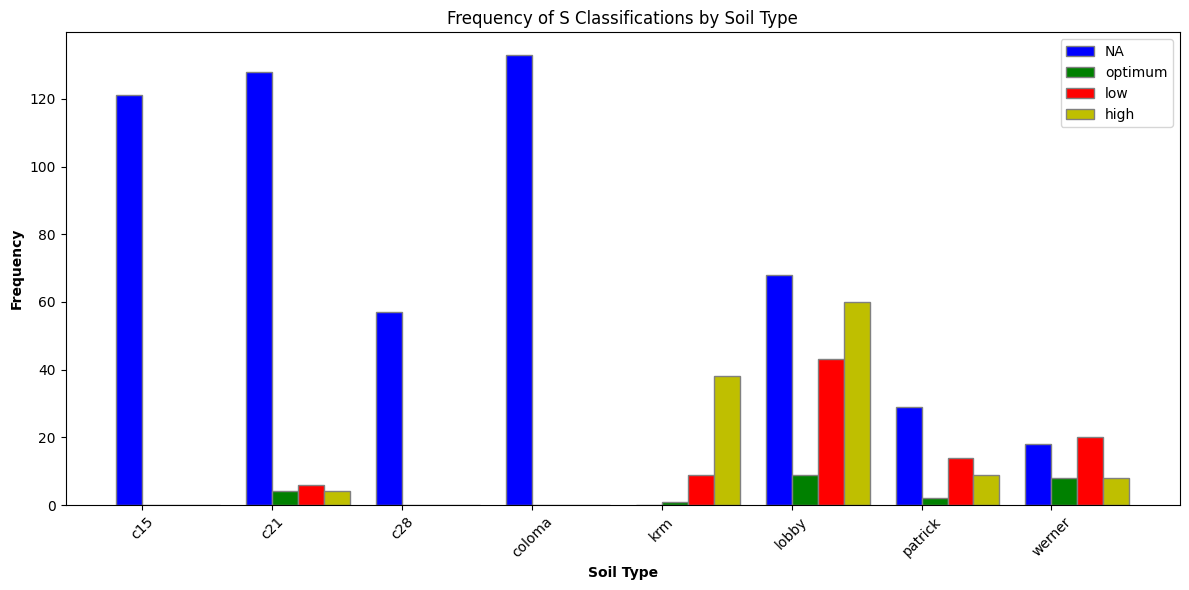

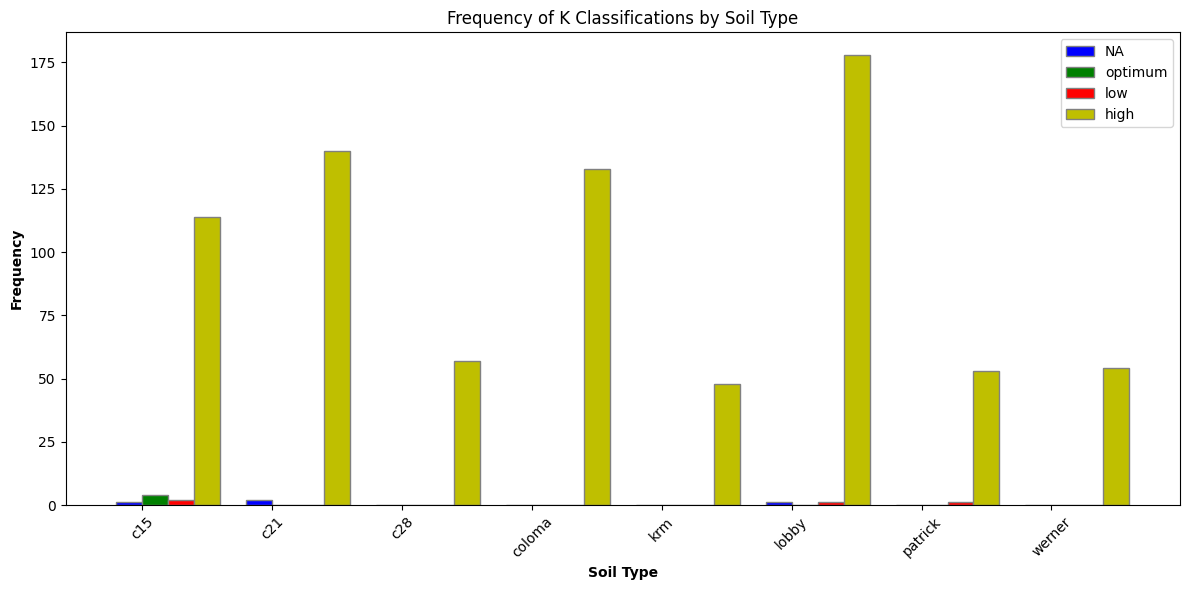

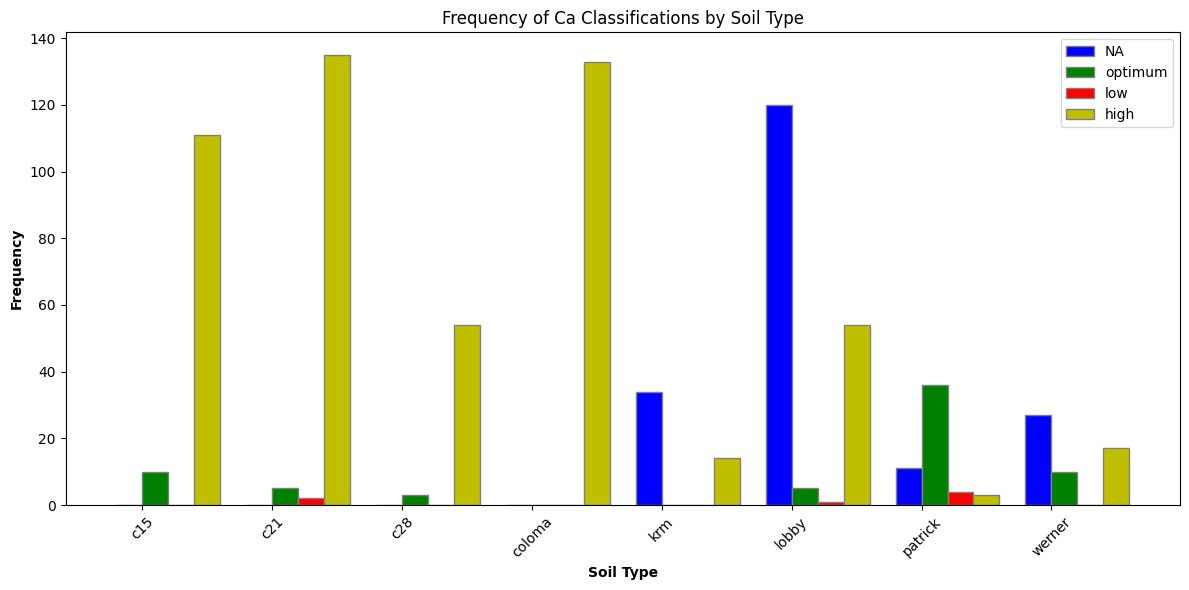

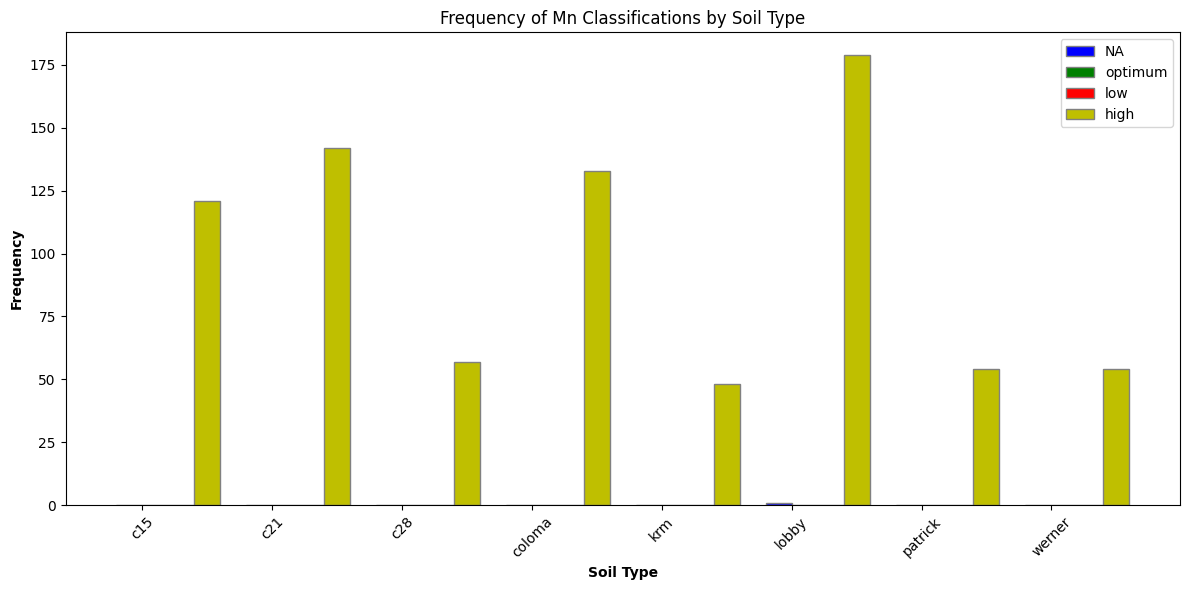

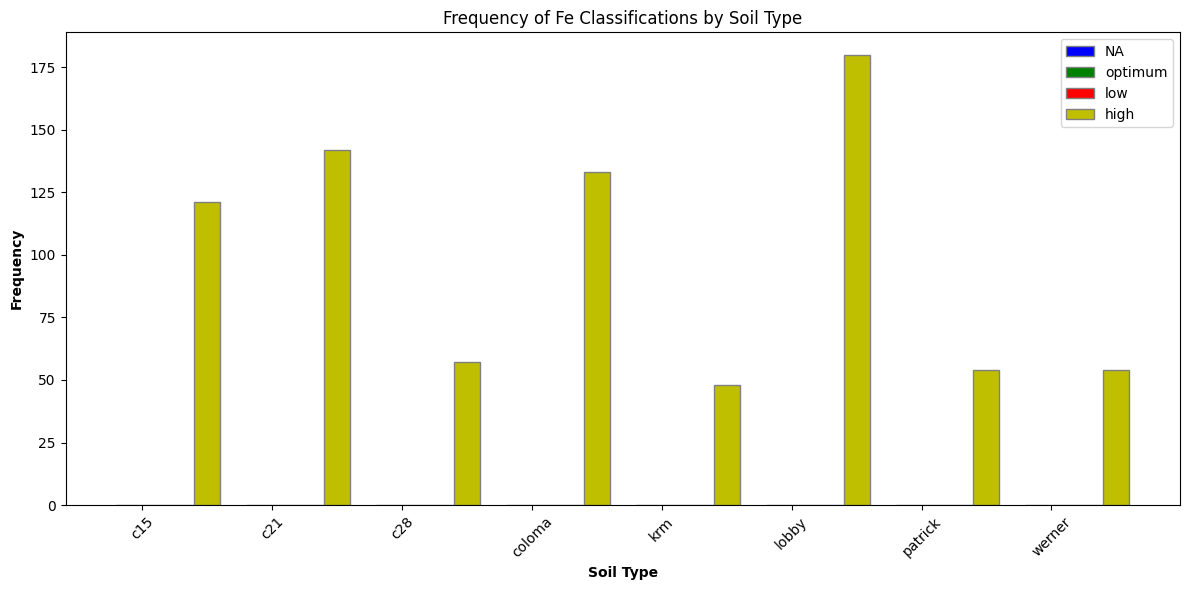

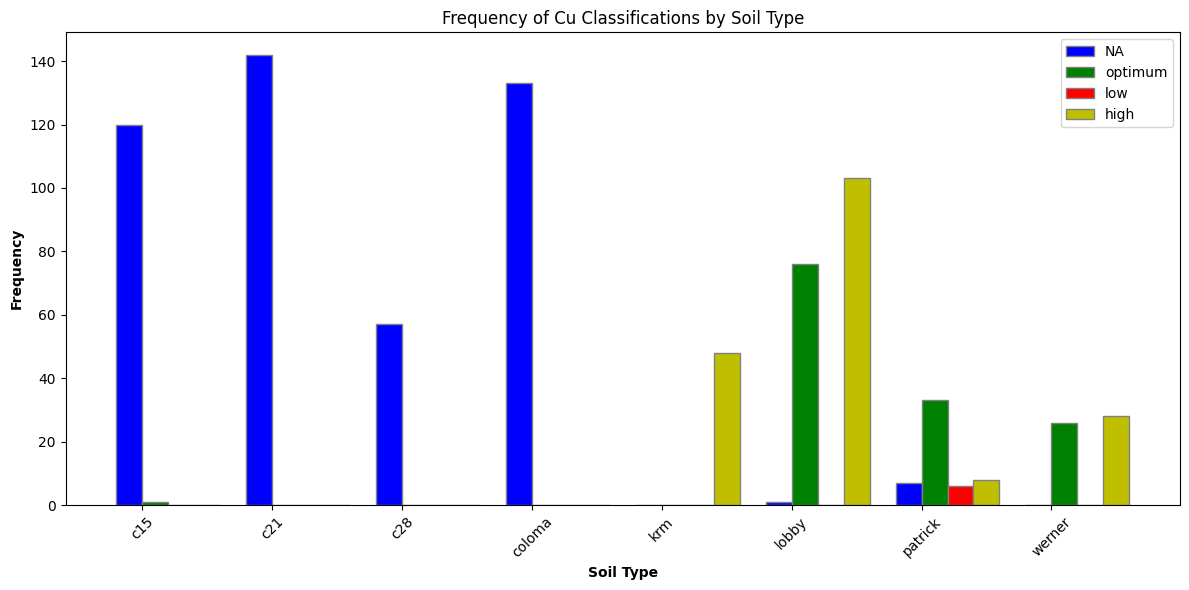

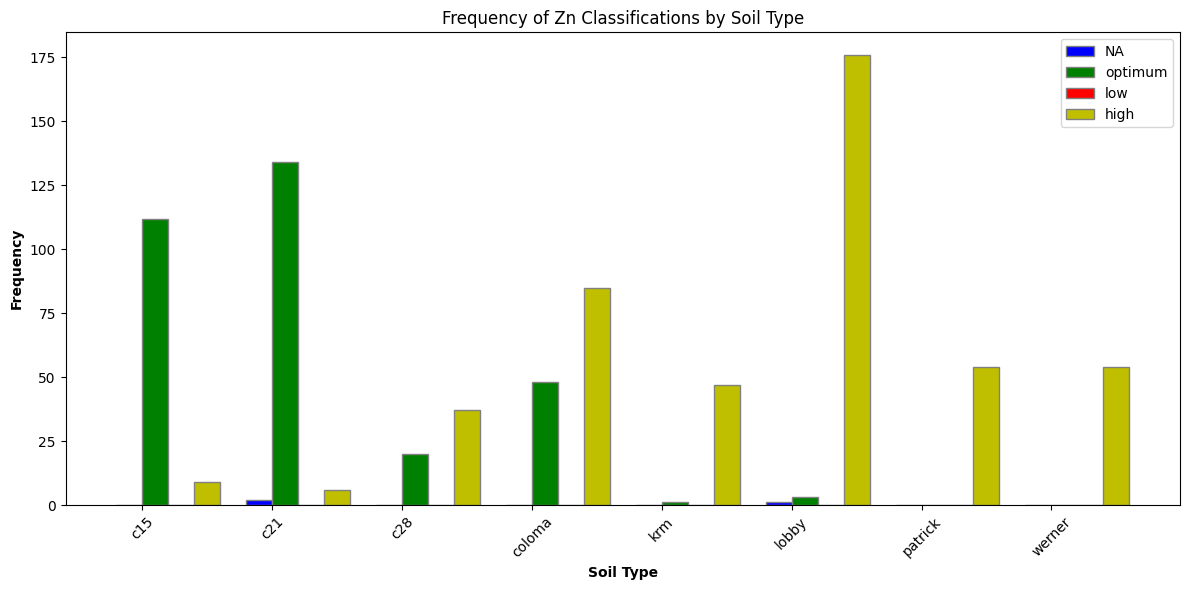

In [25]:
for element in elements:
    element_counts = calculate_element_counts(element)
    plot_element_counts(element_counts, element)

## 7. KRM dataframe

In [26]:
soil_column = 'soil'

# Create a new DataFrame with only the rows for 'krm' soil
krm_soil_df = soil_icp_df[soil_icp_df[soil_column] == 'krm']
columns_to_drop = [0, 1, 2, 3]
krm_soil_df = krm_soil_df.drop(krm_soil_df.columns[columns_to_drop], axis=1)
print(krm_soil_df)

          B       Mg        P       S        K       Ca      Mn        Fe  \
421   23.42  1751.29  1919.63  176.28   926.22     0.00  312.00   9273.93   
422   23.90  1789.68  1926.40  178.24   949.73     0.00  315.23   9320.47   
423   24.53  1783.07  1920.39  174.74   957.36     0.00  313.26   9329.47   
424  106.43  1885.32   973.37   44.59   994.17     0.00  361.62  10280.64   
425   28.36  1884.19   996.56   47.91   881.17     0.00  371.17  10493.18   
426   29.40  1886.56  1020.05   48.98   908.08     0.00  367.78  10544.74   
427   42.78  1556.95   861.22   96.43  1238.02   993.43  456.69   8911.88   
428   25.57  1495.42   900.84   98.12   879.15   949.94  457.29   8847.94   
429   37.54  1529.78   952.48  106.57  1040.39   958.50  458.94   8931.52   
430   25.49  1969.10   521.97   15.16   810.99     0.00  322.80   8610.00   
431   25.24  1962.35   526.82   14.25   804.84     0.00  319.88   8592.24   
432   25.95  1896.07   548.13   20.96   789.58     0.00  314.69   8356.15   

## 8. Pearson Correlation on KRM

           B        Mg         P         S         K        Ca        Mn  \
B   1.000000  0.235212 -0.048159 -0.074374  0.089215 -0.057069  0.079119   
Mg  0.235212  1.000000 -0.140808 -0.048961  0.130268 -0.386404 -0.382598   
P  -0.048159 -0.140808  1.000000  0.508111  0.072218  0.018886 -0.076190   
S  -0.074374 -0.048961  0.508111  1.000000  0.308264 -0.243960  0.245736   
K   0.089215  0.130268  0.072218  0.308264  1.000000 -0.152987  0.187364   
Ca -0.057069 -0.386404  0.018886 -0.243960 -0.152987  1.000000 -0.056221   
Mn  0.079119 -0.382598 -0.076190  0.245736  0.187364 -0.056221  1.000000   
Fe  0.362143  0.333460  0.348525  0.112679  0.204350 -0.157479 -0.226977   
Cu -0.191548  0.221367  0.260225  0.398668  0.386944 -0.524428  0.301515   
Zn -0.178047 -0.354427  0.019138  0.563218  0.115286 -0.197635  0.273288   

          Fe        Cu        Zn  
B   0.362143 -0.191548 -0.178047  
Mg  0.333460  0.221367 -0.354427  
P   0.348525  0.260225  0.019138  
S   0.112679  0.398668 

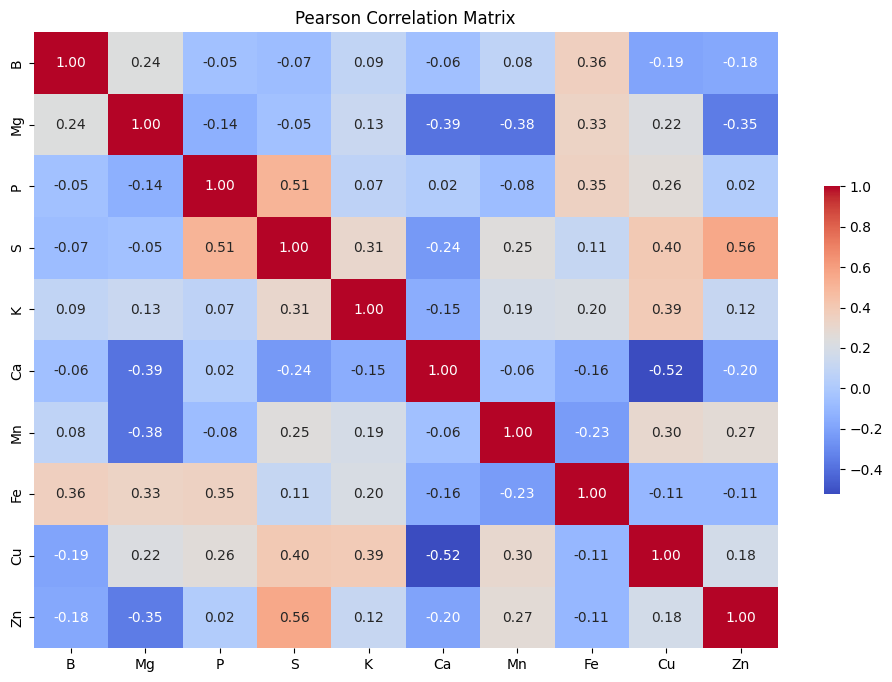

In [27]:
corr_matrix = krm_soil_df.corr(method='pearson')
print(corr_matrix)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .5})
plt.title('Pearson Correlation Matrix')
plt.show()

## 9. Factor Analysis on KRM

In [ ]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(krm_soil_df)

# Perform KMO Test
kmo_all, kmo_model = calculate_kmo(krm_soil_df)
print("KMO Test Value:", kmo_model)

# Perform Bartlett's Test
chi_square_value, p_value = calculate_bartlett_sphericity(krm_soil_df)
print("Bartlett's Test Chi-Square Value:", chi_square_value)
print("Bartlett's Test p-value:", p_value)

BAD RESULT IN THE TEST. THE DATA ARE NOT SUITABLE FOR USING A PRINCIPAL COMPONENT ANALYSIS (PCA) OR A FACTOR ANALYSIS (FA)!!!!!!!!!!!

In [32]:
# Initialize and fit the factor analysis model
n_factors = 10
fa = FactorAnalysis(n_components=n_factors, random_state=0)
X_factor = fa.fit_transform(X)

# The factor loadings (or the 'rotated' data) can be accessed via fa.components_
print("Factor Loadings:\n", fa.components_)  # Each row corresponds to a factor

# Scores of each variable on the factors
factor_scores_df = pd.DataFrame(X_factor, columns=[f'Factor{i+1}' for i in range(n_factors)])
print("Factor Scores:\n", factor_scores_df.head())

# Calculate variance explained by each factor
variance_explained = np.sum(fa.components_**2, axis=1)

# Calculate total variance explained
total_variance = np.sum(variance_explained)

# Calculate the proportion of variance explained
proportion_variance_explained = variance_explained / total_variance

Factor Loadings:
 [[-0.10934746 -0.00349068  0.38868671  0.73020556  0.42637705 -0.45554955
   0.35094612  0.07973089  0.6539917   0.50565973]
 [ 0.34783789  0.71327422  0.07535927 -0.06622671  0.18459298 -0.36258719
  -0.37294569  0.53631675  0.13309877 -0.37305067]
 [ 0.14111694 -0.20496884  0.49590865  0.23266716 -0.0282569   0.31344618
  -0.15923374  0.4132565  -0.30350058  0.03746953]
 [ 0.44038951 -0.06282701 -0.21338258 -0.02497302  0.20034574  0.00734439
   0.3451749   0.12185533 -0.11747248  0.07165029]
 [ 0.00920504  0.04271629 -0.15047379  0.07344936 -0.16874062 -0.16229156
  -0.13952324  0.04804926 -0.15774555  0.27957692]
 [-0.01876165  0.00646034 -0.01792737  0.00335266  0.04525415  0.01978814
  -0.01819841  0.00139429 -0.00729527  0.01100395]
 [ 0.          0.         -0.          0.         -0.          0.
  -0.         -0.         -0.         -0.        ]
 [ 0.         -0.          0.         -0.          0.         -0.
  -0.         -0.          0.          0.        

#### Print the results

In [33]:
print("Total Variance Explained:", total_variance)
print("Proportion of Variance Explained:", proportion_variance_explained)

Total Variance Explained: 4.68855894753299
Proportion of Variance Explained: [0.40491897 0.29624594 0.16011006 0.09324107 0.0447005  0.00078346
 0.         0.         0.         0.        ]


#### Screeplot

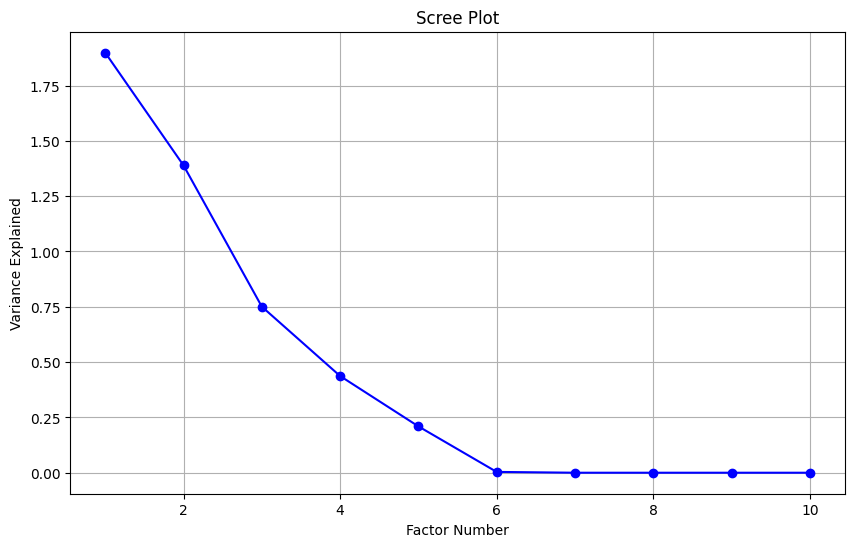

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_factors + 1), variance_explained, 'o-', color='blue')
plt.title('Scree Plot')
plt.xlabel('Factor Number')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

#### 10. PCA

In [36]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Calculate the square root of eigenvalues (variances)
sqrt_eigenvalues = np.sqrt(pca.explained_variance_)

# Scaling factors for individuals
row_scaling = 1 / sqrt_eigenvalues

# Scaling factors for variables
col_scaling = sqrt_eigenvalues

#### 11. HJ-Biplot

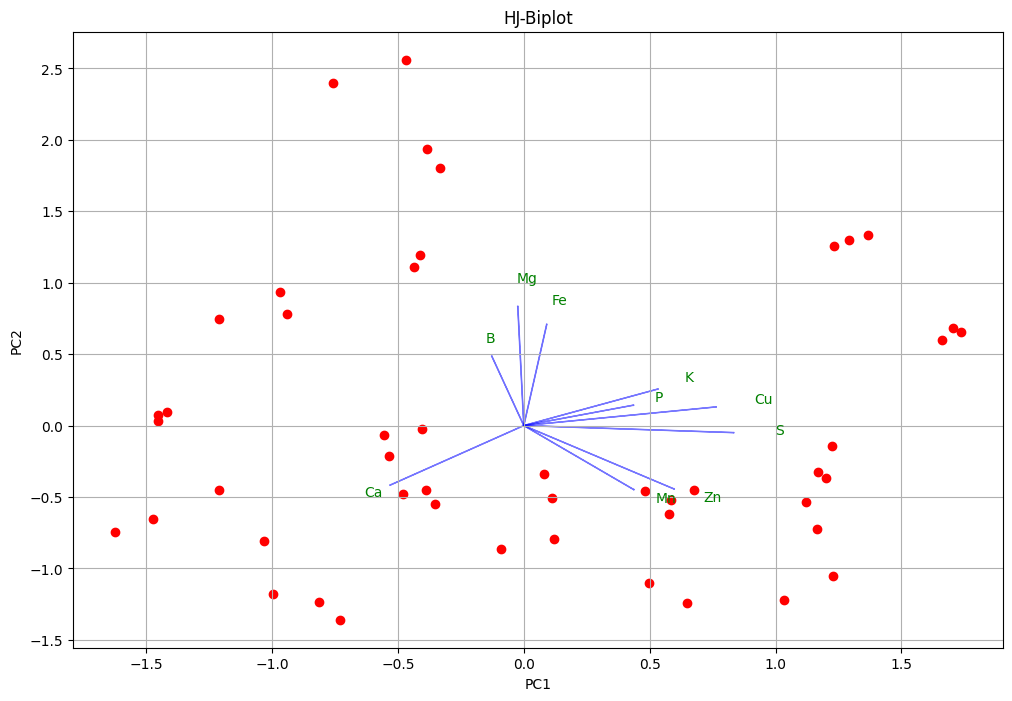

In [38]:
plt.figure(figsize=(12, 8))

# Plot individuals
for i in range(principalComponents.shape[0]):
    plt.scatter(principalComponents[i, 0] * row_scaling[0], principalComponents[i, 1] * row_scaling[1], c='r')

# Plot variables
for i in range(X.shape[1]):
    # Arrow start at (0,0), then draw the arrows
    plt.arrow(0, 0, pca.components_[0, i] * col_scaling[0], pca.components_[1, i] * col_scaling[1], color='b', alpha=0.5)
    plt.text(pca.components_[0, i] * col_scaling[0] * 1.2, pca.components_[1, i] * col_scaling[1] * 1.2, krm_soil_df.columns[i], color='g')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('HJ-Biplot')
plt.grid(True)
plt.show()

#### 12.  KRM Boxplot

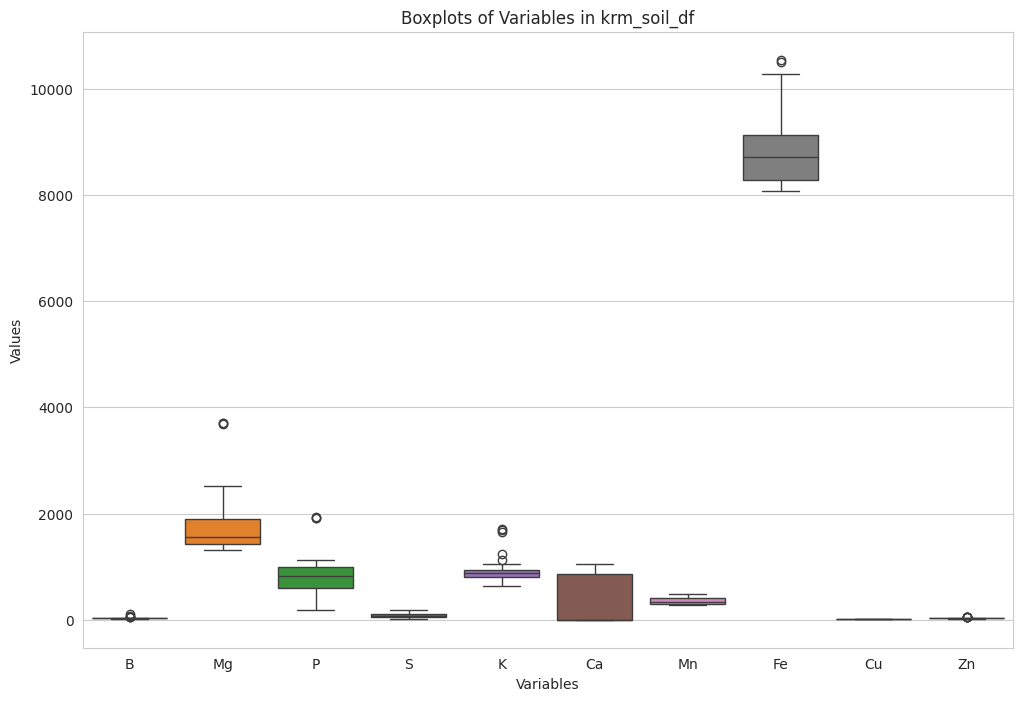

In [44]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Create a boxplot for each variable
sns.boxplot(data=krm_soil_df)

# Set title and labels (adjust as necessary)
plt.title('Boxplots of Variables in krm_soil_df')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.show()

#### 13. Transform and create a new data frame!!!

In [50]:
# Remove unused 'id' column

if 'id' in soil_icp_df.columns:
    soil_icp_df.drop('id', axis=1, inplace=True)

if 'id' in soil_hhxrf_df.columns:
    soil_hhxrf_df.drop('id', axis=1, inplace=True)

# Define the columns of interest for zero replacement
columns_to_replace = soil_icp_df.columns[3:]  # All columns after 'rep'

# Zero replacement to ensure it is applied correctly to loaded DataFrames
def replace_zeros_with_real_data(soil_icp_df, soil_hhxrf_df, columns_to_replace):

    # Create a copy of soil_icp_df to work with and keep the original data intact
    soil_mix_df = soil_icp_df.copy()
   
    # Iterate through rows of soil_icp_df
    for idx, row in soil_mix_df.iterrows():

        # Identify columns with zeros
        zero_columns = row[columns_to_replace] == 0
        zero_columns_names = zero_columns[zero_columns].index.tolist()
       
        # Continue only if there are zeros in the current row
        if zero_columns.any():

            # Find a row in soil_hhxrf_df that matches 'soil', 'sample', and 'rep'
            match = soil_hhxrf_df[
                (soil_hhxrf_df['soil'] == row['soil']) &
                (soil_hhxrf_df['sample'] == row['sample']) &
                (soil_hhxrf_df['rep'] == row['rep'])
            ]

            # If there is a corresponding row in soil_hhxrf_df and the values are non-zero, replace them in soil_mix_df
            if not match.empty:
                for column in zero_columns_names:
                    if match.iloc[0][column] != 0:
                        soil_mix_df.at[idx, column] = match.iloc[0][column]
   
    return soil_mix_df

# Call replace function with actual data
soil_mix_df_final = replace_zeros_with_real_data(soil_icp_df, soil_hhxrf_df, columns_to_replace)

# Show the corrected result with the real data
soil_mix_df_final.head()
soil_mix_df_final.to_csv('soil_mix_df_final.csv', index=False)

#### 14. Checking if the new ICP values are in the range

In [52]:
index_column = soil_icp_df.iloc[:, 0]

# Agregamos esta columna a 'soil_mix_df_final'. 
# Puedes cambiar 'nombre_nueva_columna' por el nombre real que quieras darle a la columna.

if 'id' not in soil_mix_df_final.columns:
    index_column = soil_icp_df.iloc[:, 0]
    soil_mix_df_final.insert(0, 'id', index_column)
else:
    print("Column 'id' already exists in soil_mix_df_final.")

# Mostramos el dataframe final para verificar
print(soil_mix_df_final)

# Initialize the new DataFrame
icp_classification_mix = ['id'] + list(soil_mix_df_final.columns[1:4]) + nutrients_sandy[1:]
icp_classification_mix_df = pd.DataFrame(columns=icp_classification_mix)

# Iterate over soil_mix_df_final to fill icp_classification_mix_df
for id, row in soil_mix_df_final.iterrows():
    new_id = id + 1
    new_row = [new_id] + list(row[1:4])

    # Determine soil type
    soil_name = row.iloc[1]
    soil_type = soil_types_df[soil_types_df['soil'] == soil_name]['type'].iloc[0]

    # Select the appropriate nutrient range table
    nutrient_range_df = sandy_soil_nutrient_range if soil_type == 'sandy' else soil_medium_nutrient_range

    # Compare and categorize values
    for element in nutrients_sandy[1:]:
        element_value = row[element]

        if element_value == 0:  # Check if the value is zero
            category = 'NA'  # Assign None (which will be NULL in CSV)
        else:
            lower_limit = float(nutrient_range_df[nutrient_range_df['limit'] == 'inferior'][element].iloc[0])
            upper_limit = float(nutrient_range_df[nutrient_range_df['limit'] == 'superior'][element].iloc[0])

            if element_value < lower_limit:
                category = 'low'
            elif element_value > upper_limit:
                category = 'high'
            else:
                category = 'optimum'
        
        new_row.append(category)

    icp_classification_mix_df.loc[new_id] = new_row

Column 'id' already exists in soil_mix_df_final.
         id    soil sample  rep    B      Mg        P      S       K       Ca  \
0    coloma  coloma      1    1  0.0    0.00   807.96    0.0  574.62   859.11   
1    coloma  coloma      2    1  0.0  491.76   889.15    0.0  707.79   844.07   
2    coloma  coloma      2    2  0.0  322.18  1039.74    0.0  760.43   751.79   
3    coloma  coloma      2    3  0.0  514.06   958.12    0.0  708.97   770.85   
4    coloma  coloma      3    1  0.0  677.30   818.44    0.0  606.48  1019.33   
..      ...     ...    ...  ...  ...     ...      ...    ...     ...      ...   
784     c28     c28     18    2  0.0  488.77  1529.99    0.0  486.19   612.38   
785     c28     c28     18    3  0.0  447.40  1571.24    0.0  434.23   611.24   
786     c28     c28     19    1  0.0  507.54  1643.29    0.0  535.02   642.96   
787     c28     c28     19    2  0.0  374.68  1698.38  223.0  453.04   644.39   
788     c28     c28     19    3  0.0  304.73  1721.79  200.0

#### Export icp_classification_mix_df to a CSV file

In [53]:
icp_classification_mix_df.to_csv('icp_classification_mix_df.csv', index=False)
print(icp_classification_mix_df)

      id    soil sample  rep   B    Mg     P     S     K    Ca    Mn    Fe  \
1      1  coloma      1    1  NA    NA  high    NA  high  high  high  high   
2      2  coloma      2    1  NA  high  high    NA  high  high  high  high   
3      3  coloma      2    2  NA  high  high    NA  high  high  high  high   
4      4  coloma      2    3  NA  high  high    NA  high  high  high  high   
5      5  coloma      3    1  NA  high  high    NA  high  high  high  high   
..   ...     ...    ...  ...  ..   ...   ...   ...   ...   ...   ...   ...   
785  785     c28     18    2  NA  high  high    NA  high  high  high  high   
786  786     c28     18    3  NA  high  high    NA  high  high  high  high   
787  787     c28     19    1  NA  high  high    NA  high  high  high  high   
788  788     c28     19    2  NA  high  high  high  high  high  high  high   
789  789     c28     19    3  NA  high  high  high  high  high  high  high   

       Cu       Zn  
1    high  optimum  
2    high  optimum  


#### 15. Count each type of classification in new dataframe

In [54]:
soil_column = icp_classification_mix_df.columns[1]

def calculate_element_counts(element_column):
    # Group by soil type and count occurrences of each classification, including 'NA' as a string
    element_counts = icp_classification_mix_df.groupby(soil_column)[element_column].value_counts().unstack(fill_value=0)

    # Add missing columns with default value 0 if they do not exist
    for col in ['NA', 'optimum', 'low', 'high']:
        if col not in element_counts.columns:
            element_counts[col] = 0

    # Reorder columns
    element_counts = element_counts[['NA', 'optimum', 'low', 'high']]

    # Reset index to make 'soil' a column
    element_counts.reset_index(inplace=True)

    return element_counts

# List of element columns to process
elements = ['B', 'Mg', 'P', 'S', 'K', 'Ca', 'Mn', 'Fe', 'Cu', 'Zn']

# Calculate and print counts for each element
for element in elements:
    element_counts = calculate_element_counts(element)
    print(f"--{element} table--")
    print(element_counts)

--B table--
B     soil   NA  optimum  low  high
0      c15  120        0    0     1
1      c21  141        0    0     1
2      c28   57        0    0     0
3   coloma  129        0    0     4
4      krm    0        0    0    48
5    lobby   30       11    0   139
6  patrick   15        0    0    39
7   werner    0        0    0    54
--Mg table--
Mg     soil  NA  optimum  low  high
0       c15   2       10    0   109
1       c21  42        5    3    92
2       c28   0        2    0    55
3    coloma   1       17    0   115
4       krm   0        0    0    48
5     lobby   1        0    0   179
6   patrick   0        2    0    52
7    werner   0        0    0    54
--P table--
P     soil  NA  optimum  low  high
0      c15   0        2    4   115
1      c21   0        3    2   137
2      c28   0        0    0    57
3   coloma   0        0    0   133
4      krm   0        0    0    48
5    lobby   0        0    1   179
6  patrick   1        1    0    52
7   werner   0        0    0    54


#### 16. Bar charts for each element in new data frame

In [57]:
def plot_element_counts(element_counts, element_name):
    # Set figure size for better readability
    plt.figure(figsize=(12, 6))

    # Number of soil types
    n_soils = len(element_counts)
    # Width of a bar
    bar_width = 0.2

    # Positions of bars on the x-axis
    r1 = np.arange(n_soils)
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]

    # Plotting the data
    plt.bar(r1, element_counts['NA'], color='b', width=bar_width, edgecolor='gray', label='NA')
    plt.bar(r2, element_counts['optimum'], color='g', width=bar_width, edgecolor='gray', label='optimum')
    plt.bar(r3, element_counts['low'], color='r', width=bar_width, edgecolor='gray', label='low')
    plt.bar(r4, element_counts['high'], color='y', width=bar_width, edgecolor='gray', label='high')

    # Adding labels and title
    plt.xlabel('Soil Type', fontweight='bold')
    plt.ylabel('Frequency', fontweight='bold')
    plt.xticks([r + bar_width/2 for r in range(n_soils)], element_counts[soil_column], rotation=45)
    plt.title(f'Frequency of {element_name} Classifications by Soil Type')
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

#### Calculate counts and plot graph for each element

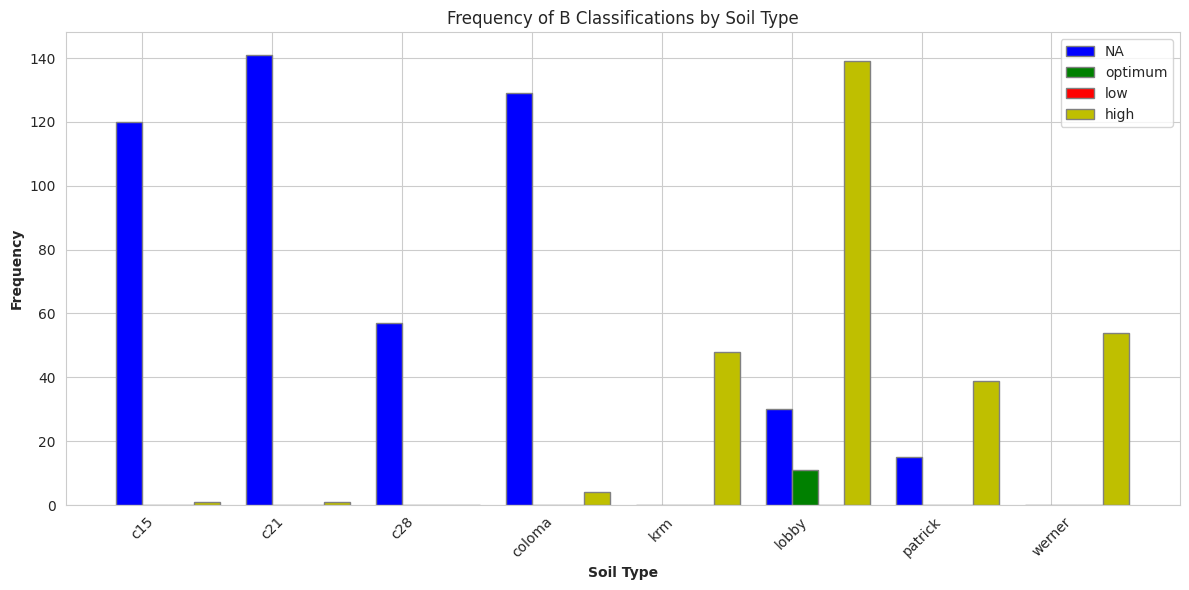

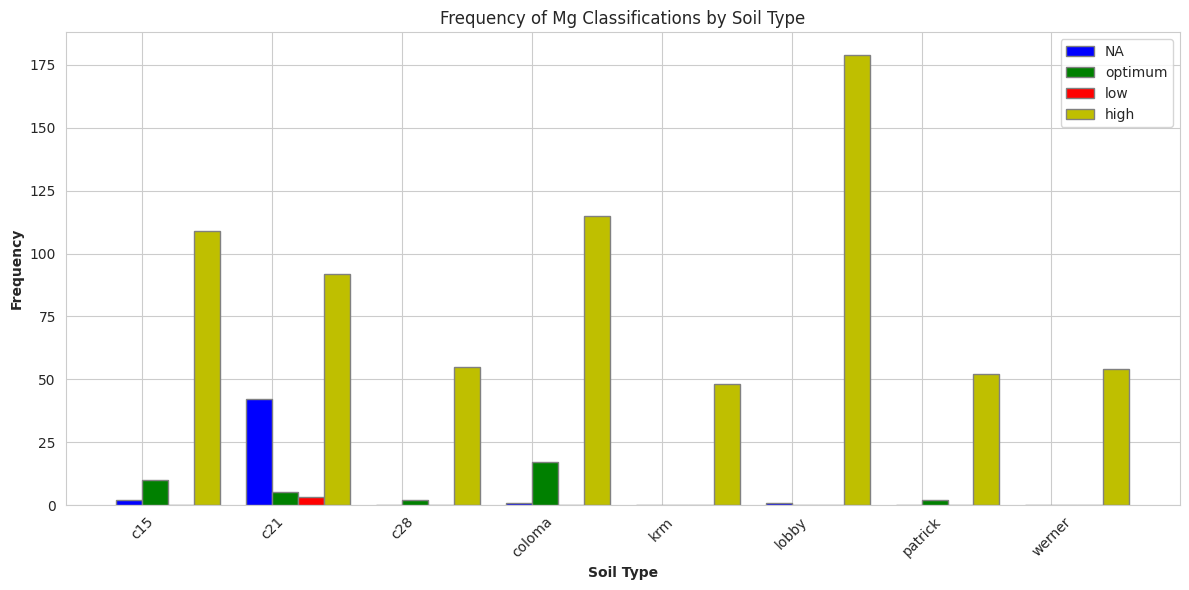

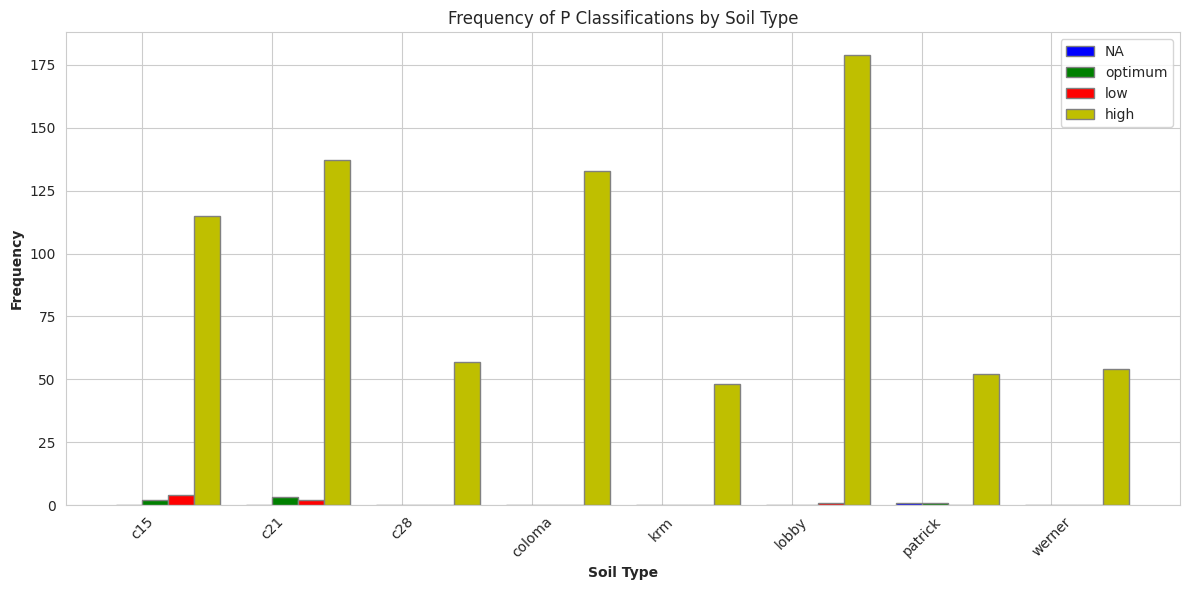

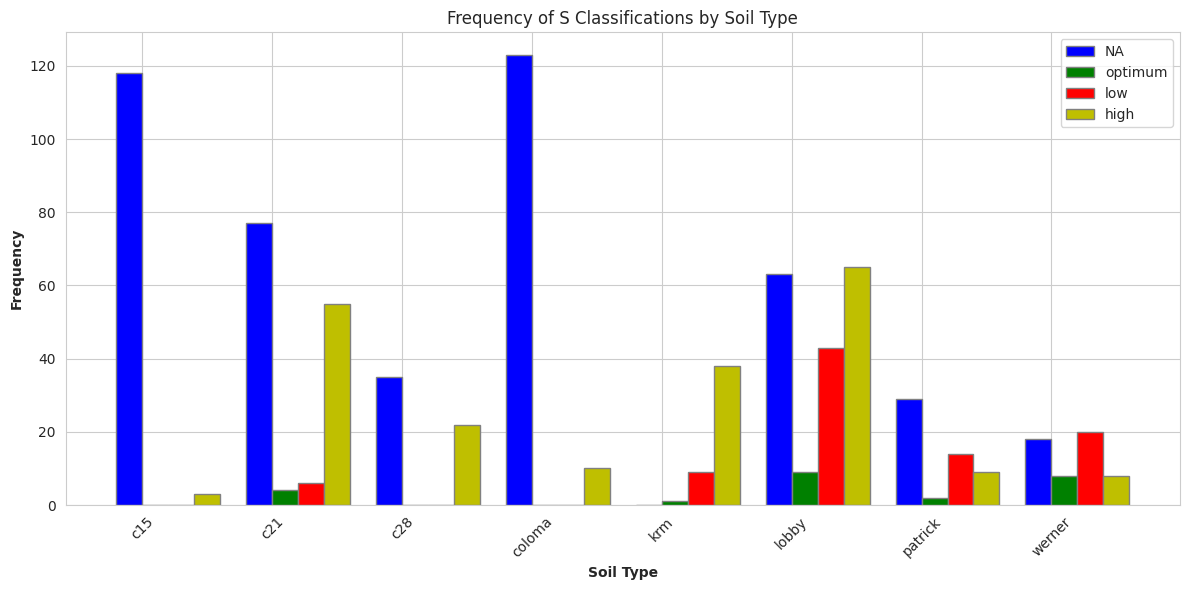

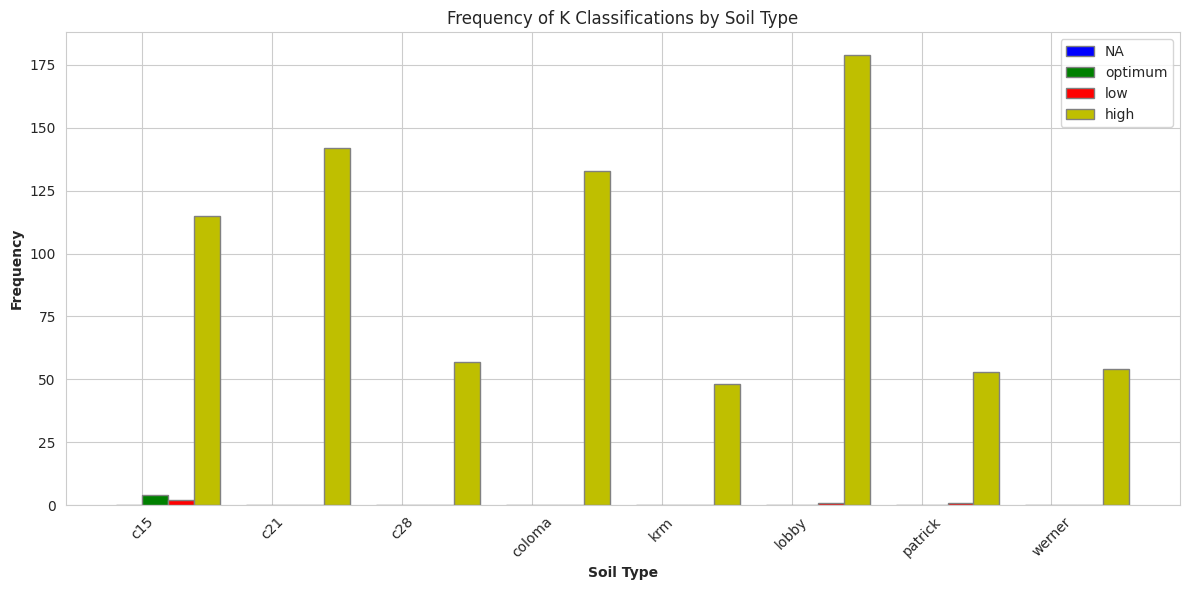

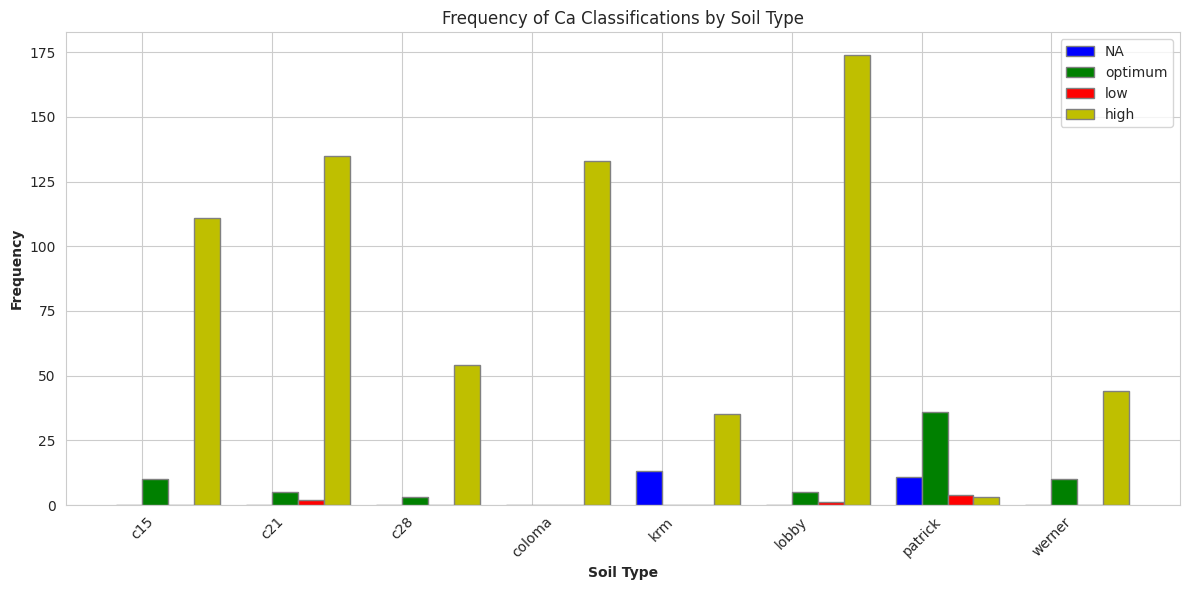

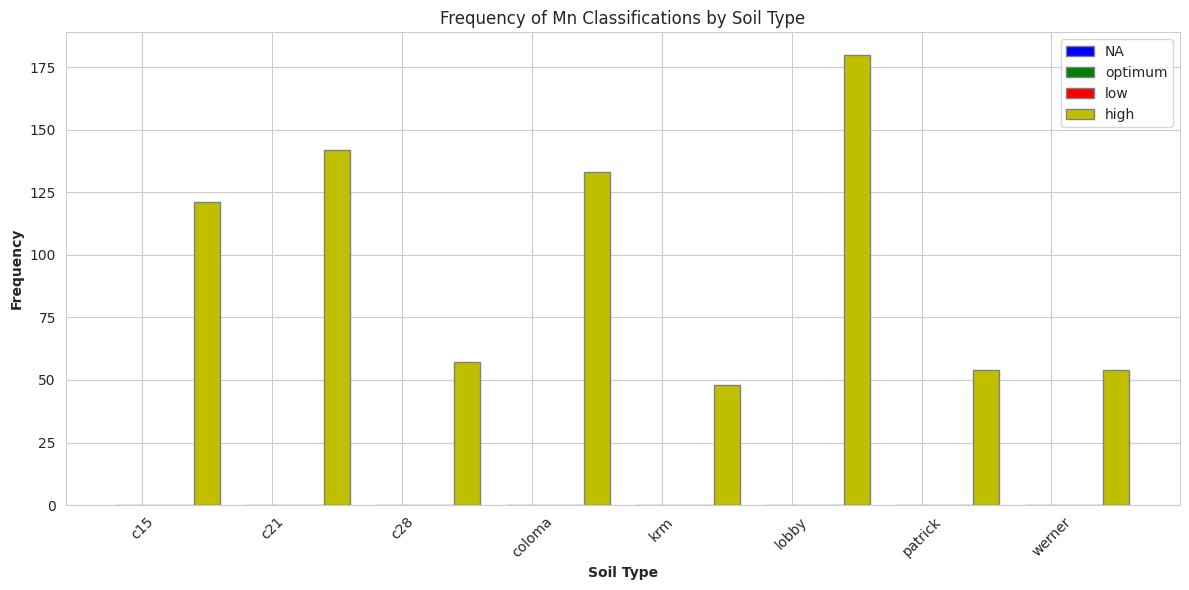

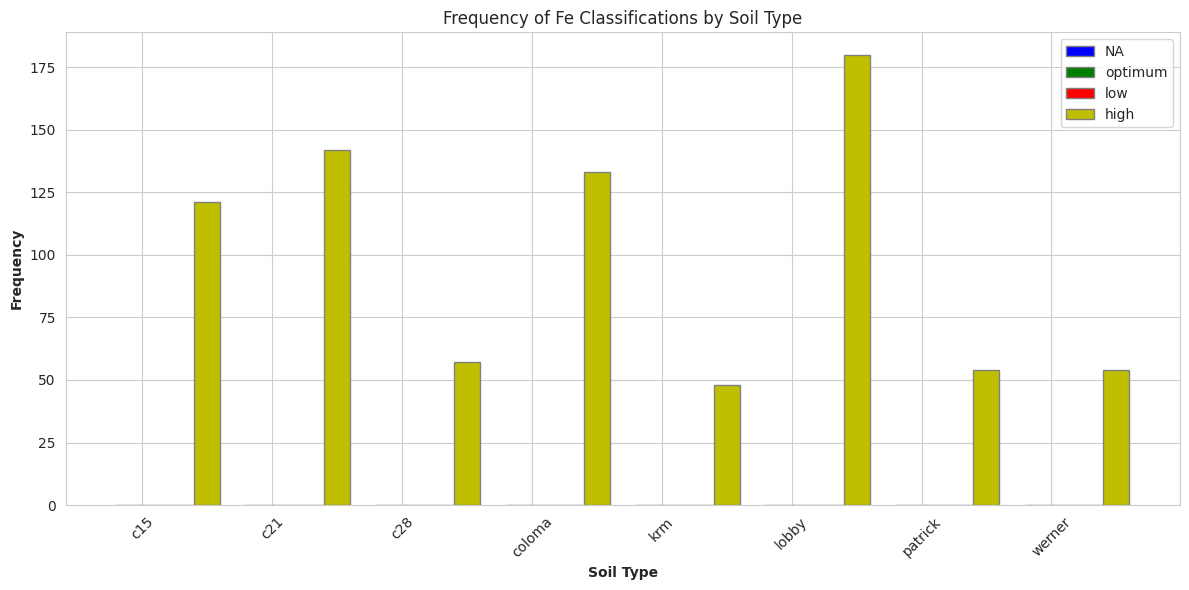

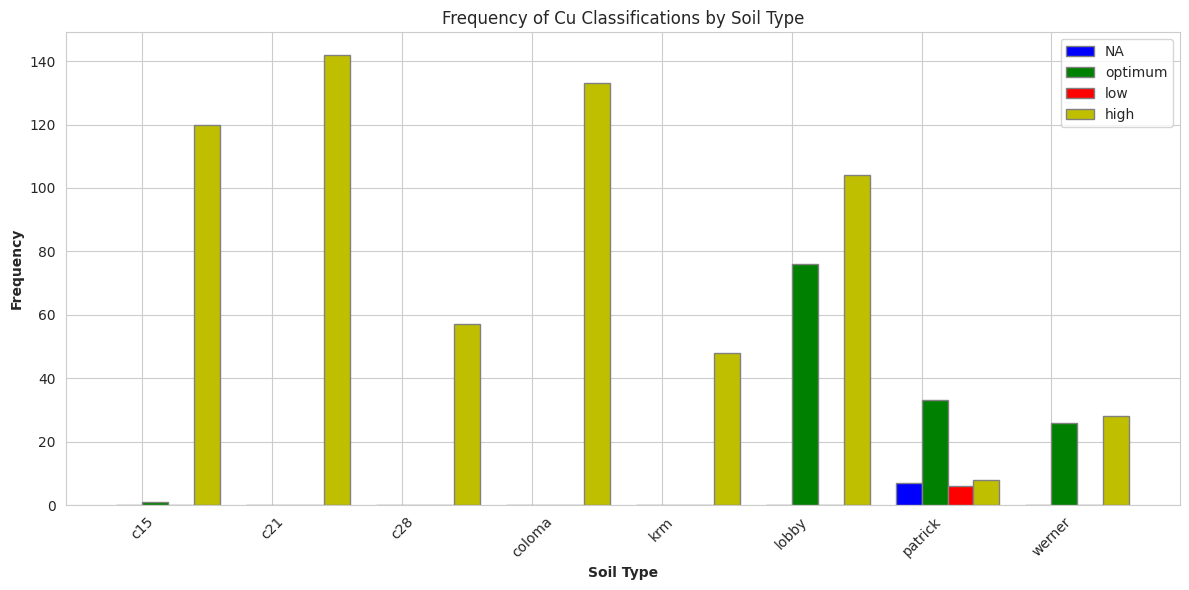

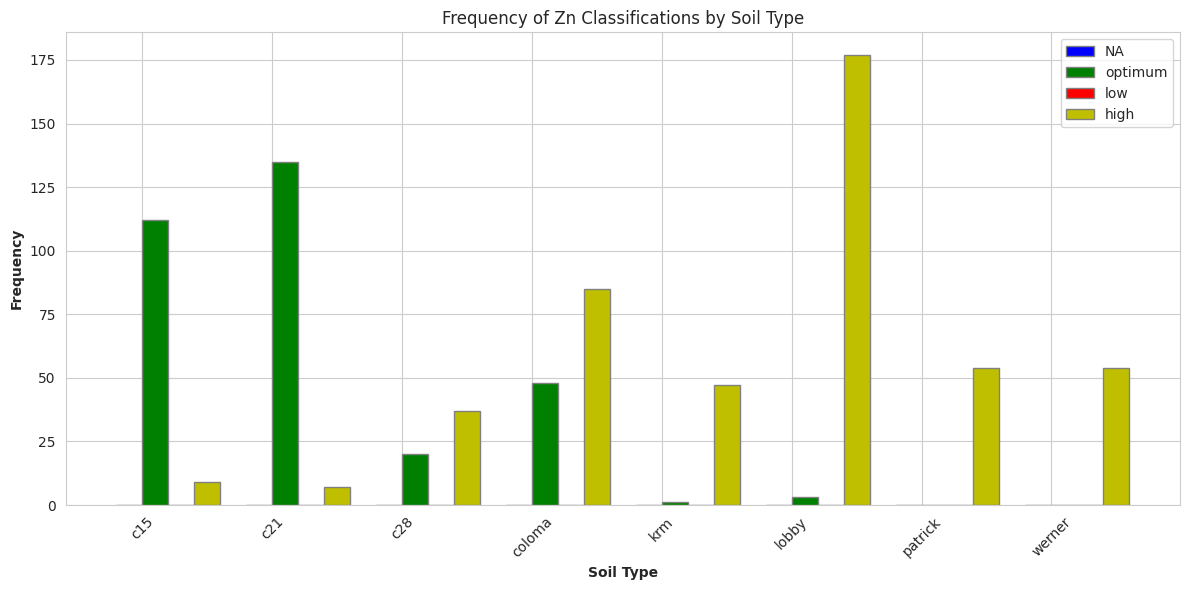

In [58]:
for element in elements:
    element_counts = calculate_element_counts(element)
    plot_element_counts(element_counts, element)